In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
CUDA = True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lrD = 5e-5
lrG = 4e-4
seed = 1

In [3]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.6.0+cu118
CUDA version: 11.8



In [4]:
def statsTensor(t:torch.Tensor)->tuple[float, ...]:
    t = t.detach().cpu()
    return (t.min().item(), t.max().item(), t.mean().item(), t.std().item())

In [5]:
# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=False,
                     transform=transforms.Compose([transforms.Resize(X_DIM), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
                     target_transform=lambda x: nn.functional.one_hot(torch.tensor(x, dtype=torch.long), num_classes=10).type(torch.float))

# Dataloader
dataloader: list[tuple[torch.Tensor, torch.Tensor]] = \
    list(torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True))

In [6]:
def showImagesPan(batchImagesOutput:torch.Tensor, title:str|None=None, show:bool=True)->None:
    nrow = int(batchImagesOutput.size(0)**0.5)
    imagesPan = vutils.make_grid(batchImagesOutput.to(device), nrow=nrow, padding=2, normalize=True).cpu()
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(np.transpose(imagesPan, (1,2,0)))
    if show is True: plt.show()

(-1.0, 1.0, -0.7461193799972534, 0.5701088905334473)


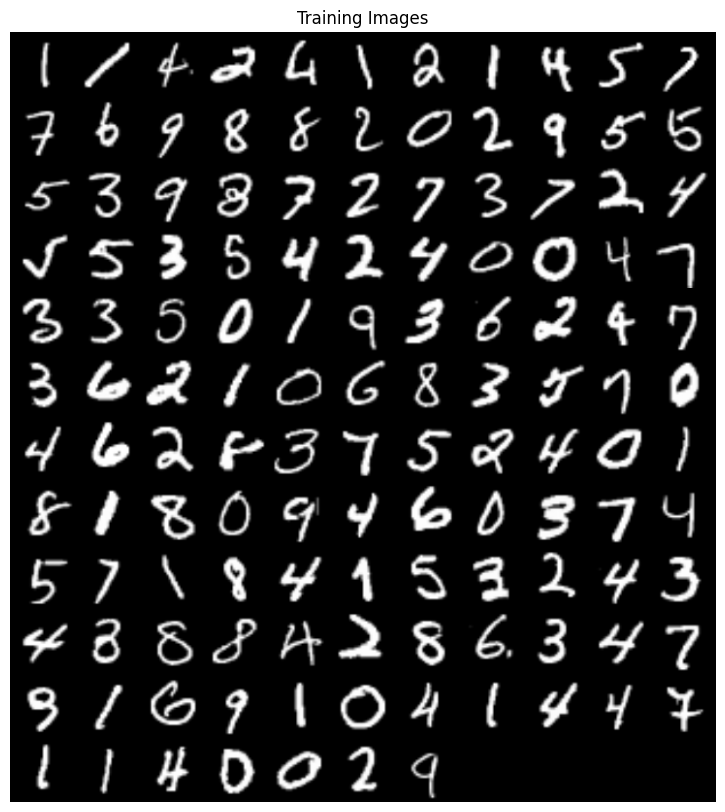

In [7]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
print(statsTensor(real_batch[0]))
showImagesPan(real_batch[0], "Training Images")
#print(real_batch[1][14*8+12])

(-1.0, 1.0, -0.7387431263923645, 0.5784310698509216)


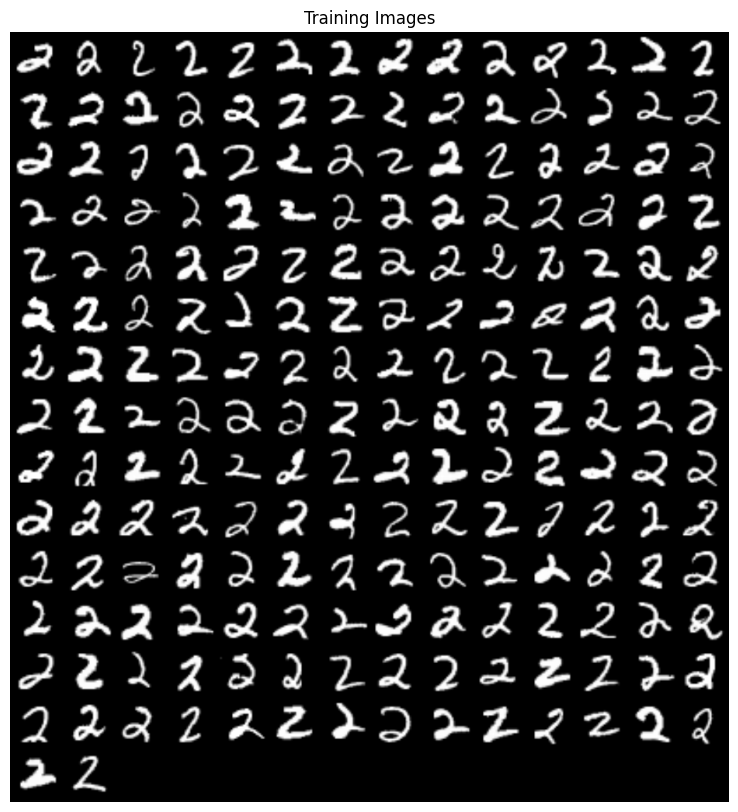

In [8]:
# Plot training images
real_imgs = torch.cat([d for d, t in dataloader[: 15]], dim=0)
real_targets = torch.cat([t for d, t in dataloader[: 15]], dim=0)
print(statsTensor(real_imgs))

plt.figure(figsize=(10,10))
showImagesPan(real_imgs[(real_targets[:, 2] == 1)], "Training Images")

In [9]:
def weights_init(m):
    return 
    classname = m.__class__.__name__
    if 'Conv' in classname:
        m.weight.data.normal_(0.0, 0.02)
    elif 'BatchNorm' in classname:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
class Generator(nn.Module):
    """Generator: (noise, classes) -> img\n
    noise of shape -1x100x1x1 and values in R normal(0, 1)\n
    classes of shape -1 and values in [0, 1])\n
    img of shape -1x1x64x64 and values in [-1, +1]"""
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM + 10, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise:torch.Tensor, targets:torch.Tensor, verbose=False)->torch.Tensor:
        """noise of shape Z_DIM | targets of shape -1x10"""
        targets = (2*targets - 1).view(-1, 10, 1, 1)
        x = torch.cat([noise, targets], dim=1)
        if verbose: print(f"input is {x.shape}")
        i: int = 0
        for i, layer in enumerate(self.main):
            x = layer(x)
            if verbose: print(f"out of {i}-{layer._get_name()} is {'x'.join(map(str, x.shape[1: ]))}")
        return x

def test():
    model = Generator()
    rawImgs, targets = next(iter(dataloader))
    noises = torch.randn(rawImgs.size(0), Z_DIM, 1, 1)
    #print(f"{statsTensor(noises)=}")
    y = model.forward(noises, targets, verbose=True)
    assert y.shape == (BATCH_SIZE, 1, X_DIM, X_DIM)

test()

input is torch.Size([128, 110, 1, 1])
out of 0-ConvTranspose2d is 512x4x4
out of 1-BatchNorm2d is 512x4x4
out of 2-ReLU is 512x4x4
out of 3-ConvTranspose2d is 256x8x8
out of 4-BatchNorm2d is 256x8x8
out of 5-ReLU is 256x8x8
out of 6-ConvTranspose2d is 128x16x16
out of 7-BatchNorm2d is 128x16x16
out of 8-ReLU is 128x16x16
out of 9-ConvTranspose2d is 64x32x32
out of 10-BatchNorm2d is 64x32x32
out of 11-ReLU is 64x32x32
out of 12-ConvTranspose2d is 1x64x64
out of 13-Tanh is 1x64x64


In [11]:
class Discriminator(nn.Module):
    """Discriminator: img -> (label, classes)\n
    img of shape -1x1x64x64 and values in [-1, +1]\n
    label of shape -1 and values in {0 fake, 1 real}\n
    classes of shape -1 and values in R (raw logits)"""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False), # 64x32x32
            nn.LeakyReLU(0.2, inplace=True), # 64x32x32
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False), # 128x16x16
            nn.BatchNorm2d(D_HIDDEN * 2), # 128x16x16
            nn.LeakyReLU(0.2, inplace=True), # 128x16x16
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False), # 256x8x8
            nn.BatchNorm2d(D_HIDDEN * 4), # 256x8x8
            nn.LeakyReLU(0.2, inplace=True), # 256x8x8
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 2, 4, 2, 1, bias=False), # 128x4x4
            nn.BatchNorm2d(D_HIDDEN * 2), # 128x4x4
            nn.LeakyReLU(0.2, inplace=True), # 128x4x4
            # output layer
            nn.Flatten(), # 2048
        )
        self.toLabel = nn.Sequential(
            nn.Linear(4*4*D_HIDDEN*2, D_HIDDEN*8), # 512
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(D_HIDDEN*8, D_HIDDEN*4), # 128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(D_HIDDEN*4, 1), # 1
            nn.Sigmoid(),
        )
        self.toClasses = nn.Sequential(
            nn.Linear(4*4*D_HIDDEN*2, D_HIDDEN*8), # 512
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(D_HIDDEN*8, D_HIDDEN*4), # 128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(D_HIDDEN*4, 10), # 10
        )

    def forward(self, imgs:torch.Tensor, verbose:bool=False)->tuple[torch.Tensor, torch.Tensor]:
        """img of shape -1x1x64x64"""
        if verbose: print(f"input is {imgs.shape}")
        # main part
        if verbose: print("main part")
        x = imgs 
        for i, layer in enumerate(self.main):
            x = layer(x)
            if verbose: print(f"out of {i}-{layer._get_name()} is {'x'.join(map(str, x.shape[1: ]))}")
        # classes part
        if verbose: print("toClasses part")
        classes = x
        for i, layer in enumerate(self.toClasses):
            classes = layer(classes)
            if verbose: print(f"out of {i}-{layer._get_name()} is {'x'.join(map(str, classes.shape[1: ]))}")
        # label part
        label = x
        if verbose: print("toLabel part")
        for i, layer in enumerate(self.toLabel):
            label = layer(label)
            if verbose: print(f"out of {i}-{layer._get_name()} is {'x'.join(map(str, label.shape[1: ]))}")
        return (label.squeeze(), classes)

def test():
    model = Discriminator()
    rawImgs, targets = next(iter(dataloader))
    print(f"{statsTensor(rawImgs)=}")
    #print(f"{statsTensor(targets)=}")
    batchSize = rawImgs.size(0)
    (label, classes) = model.forward(rawImgs.to(torch.float32), verbose=True)
    print(f"{statsTensor(label)=}")
    print(f"{statsTensor(classes)=}")
    assert label.shape == (batchSize, ) and classes.shape == (batchSize, 10)
    #print(f"{label.shape=}")
    

test()



statsTensor(rawImgs)=(-1.0, 1.0, -0.7461193799972534, 0.5701088905334473)
input is torch.Size([128, 1, 64, 64])
main part
out of 0-Conv2d is 64x32x32
out of 1-LeakyReLU is 64x32x32
out of 2-Conv2d is 128x16x16
out of 3-BatchNorm2d is 128x16x16
out of 4-LeakyReLU is 128x16x16
out of 5-Conv2d is 256x8x8
out of 6-BatchNorm2d is 256x8x8
out of 7-LeakyReLU is 256x8x8
out of 8-Conv2d is 128x4x4
out of 9-BatchNorm2d is 128x4x4
out of 10-LeakyReLU is 128x4x4
out of 11-Flatten is 2048
toClasses part
out of 0-Linear is 512
out of 1-LeakyReLU is 512
out of 2-Linear is 256
out of 3-LeakyReLU is 256
out of 4-Linear is 10
toLabel part
out of 0-Linear is 512
out of 1-LeakyReLU is 512
out of 2-Linear is 256
out of 3-LeakyReLU is 256
out of 4-Linear is 1
out of 5-Sigmoid is 1
statsTensor(label)=(0.44086456298828125, 0.5120970010757446, 0.4803786277770996, 0.01338923629373312)
statsTensor(classes)=(-0.22384503483772278, 0.24544191360473633, 0.0011579168494790792, 0.08157722651958466)


In [12]:
import attrs
@attrs.frozen
class TrainBatchStepResults():
    epoch: int
    batch: int
    sizeOfBatch: int
    # correct labels
    discRealCorrectLabels: int
    discFakeCorrectLabels: int
    genCorrectLabels: int
    # correct classes
    discRealCorrectClasses: int
    discFakeCorrectClasses: int
    genCorrectClasses: int
    # labels losses
    discRealLabelLoss: float
    discFakeLabelLoss: float
    genLabelLoss: float
    # classes losses
    discRealClassesLoss: float
    discFakeClassesLoss: float
    genClassesLoss: float
    # stats on images
    realImgMean: float
    fakeImgMean: float
    realImgStd: float
    fakeImgStd: float

    @property
    def bSize(self)->int:
        return self.sizeOfBatch

    def toText(self, lastEpoch:int, nbBatchs:int)->str:
        return f"epoch n°{self.epoch+1}/{lastEpoch}, batch:{self.batch+1}/{nbBatchs} - " \
            f"lossLabels({self.discRealLabelLoss:.3g}, {self.discFakeLabelLoss:.3g}, {self.genLabelLoss:.3g}) - " \
            f"correctLabels({self.discRealCorrectLabels/self.bSize:.1%}, {self.discFakeCorrectLabels/self.bSize:.1%}, {self.genCorrectLabels/self.bSize:.1%}) - " \
            f"lossClasses({self.discRealClassesLoss:.3g}, {self.discFakeClassesLoss:.3g}, {self.genClassesLoss:.3g}) - " \
            f"correctClasses({self.discRealCorrectClasses/self.bSize:.1%}, {self.discFakeCorrectClasses/self.bSize:.1%}, {self.genCorrectClasses/self.bSize:.1%}) - " \
            f"mean({self.realImgMean:.3g}, {self.fakeImgMean:.3g}) - std({self.realImgStd:.3g}, {self.fakeImgStd:.3g})"
    
    @staticmethod
    def accumPerEpochStats(batchsResults:list["TrainBatchStepResults"])->"list[TrainBatchStepResults]":
        """acccumulate the results for batchs to results per epoch"""
        epochsGrps: dict[int, list[TrainBatchStepResults]] = {}
        for t in batchsResults:
            if t.epoch not in epochsGrps.keys():
                epochsGrps[t.epoch] = []
            epochsGrps[t.epoch].append(t)
        result: "list[TrainBatchStepResults]" = []
        for _, statsOfEpoch in sorted(epochsGrps.items()):
            result.append(TrainBatchStepResults.accumEpochResults(statsOfEpoch))
        return result
        
    
    @staticmethod
    def accumEpochResults(results:list["TrainBatchStepResults"])->"TrainBatchStepResults":
        """acccumulate the results for 1 epoch"""
        assert len(_ := set(t.epoch for t in results)) == 1, f"not the same epochs: {_}"
        batches = [t.batch for t in results]
        assert len(_ := {b for b in batches if batches.count(b)>1}) == 0, f"repeted batches: {_}"
        del batches
        # accumulate the results
        kwargs: dict[str, int|float] = {"epoch": results[0].epoch, "batch": -1, }
        kwargs["sizeOfBatch"] = sum(t.bSize for t in results)
        for kw in TrainBatchStepResults.__annotations__.keys():
            if kw in ("epoch", "batch", "sizeOfBatch"): continue
            elif kw.endswith("Loss") or "Img" in kw: # do weigthed avg
                kwargs[kw] = sum(t.__getattribute__(kw) * t.bSize for t in results)
                kwargs[kw] /= kwargs["sizeOfBatch"]
            elif "Correct" in kw: # summ the results
                kwargs[kw] = sum(t.__getattribute__(kw) for t in results)
            else: raise ValueError(f"unhandled {kw=}")
        return TrainBatchStepResults(**kwargs)
        
        
        

In [17]:

# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)
print(f'-> {sum(p.numel() for p in netG.parameters()):_d} parameters')

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)
print(f'-> {sum(p.numel() for p in netD.parameters()):_d} parameters')

epoch: int = -1
batchesStats: list[TrainBatchStepResults] = []

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [18]:
# Initialize BCELoss function
labelCriterion = nn.BCELoss()
ClassesCriterion = nn.CrossEntropyLoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_targets = dataloader[0][1].to(device)
viz_noise = torch.randn(viz_targets.size(0), Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(0.5, 0.999))

In [19]:
def computeNbCorrectLabels(pred:torch.Tensor, truth:torch.Tensor)->int:
    return int(((pred.detach() >= 0.5) == truth.detach()).sum().cpu().item())

def computeNbCorrectClasses(pred:torch.Tensor, truth:torch.Tensor)->int:
    pred = pred.detach().argmax(dim=1)
    truth = truth.detach().argmax(dim=1)
    return int((pred == truth).sum().cpu().item())

Starting Training Loop...
epoch n°1/5, batch:1/469 - lossLabels(0.644, 0.754, 0.679) - correctLabels(100.0%, 0.8%, 68.0%) - lossClasses(2.3, 2.3, 2.27) - correctClasses(7.0%, 8.6%, 17.2%) - mean(-0.746, -0.17) - std(0.57, 0.704)


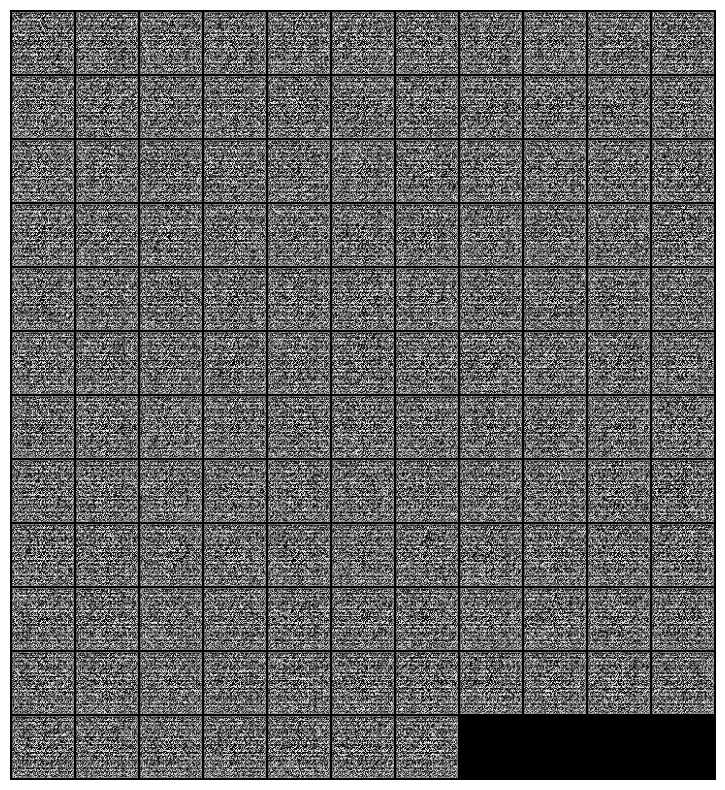

epoch n°1/5, batch:2/469 - lossLabels(0.588, 0.852, 0.606) - correctLabels(100.0%, 0.0%, 100.0%) - lossClasses(2.29, 2.3, 2.28) - correctClasses(13.3%, 12.5%, 18.0%) - mean(-0.734, -0.162) - std(0.585, 0.72)
epoch n°1/5, batch:3/469 - lossLabels(0.552, 0.938, 0.567) - correctLabels(100.0%, 0.0%, 100.0%) - lossClasses(2.25, 2.28, 2.26) - correctClasses(30.5%, 20.3%, 22.7%) - mean(-0.738, -0.166) - std(0.578, 0.733)
epoch n°1/5, batch:4/469 - lossLabels(0.521, 0.978, 0.558) - correctLabels(100.0%, 0.0%, 100.0%) - lossClasses(2.23, 2.28, 2.26) - correctClasses(34.4%, 18.8%, 25.8%) - mean(-0.74, -0.175) - std(0.578, 0.746)
epoch n°1/5, batch:5/469 - lossLabels(0.496, 0.992, 0.558) - correctLabels(100.0%, 0.0%, 100.0%) - lossClasses(2.21, 2.26, 2.24) - correctClasses(40.6%, 23.4%, 27.3%) - mean(-0.733, -0.183) - std(0.586, 0.741)
epoch n°1/5, batch:6/469 - lossLabels(0.488, 0.993, 0.559) - correctLabels(100.0%, 0.0%, 100.0%) - lossClasses(2.18, 2.25, 2.23) - correctClasses(51.6%, 25.8%, 28.

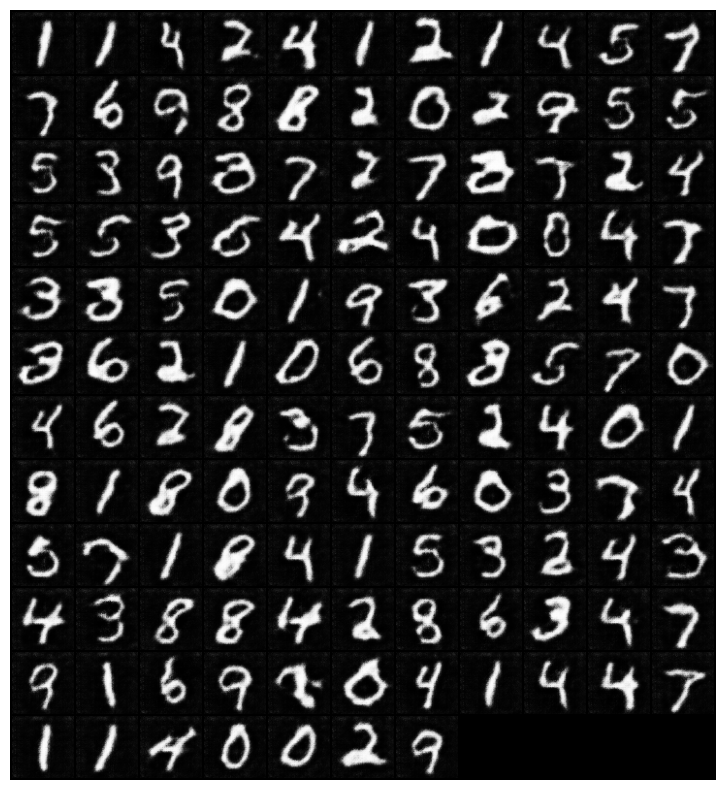

epoch n°2/5, batch:2/469 - lossLabels(1.44, 0.148, 0.455) - correctLabels(1.6%, 100.0%, 93.0%) - lossClasses(0.176, 0.00968, 0.00834) - correctClasses(95.3%, 100.0%, 100.0%) - mean(-0.734, -0.699) - std(0.585, 0.548)
epoch n°2/5, batch:3/469 - lossLabels(0.185, 1.56, 1.56) - correctLabels(100.0%, 0.0%, 0.0%) - lossClasses(0.0844, 0.0186, 0.0144) - correctClasses(96.9%, 99.2%, 100.0%) - mean(-0.738, -0.696) - std(0.578, 0.56)
epoch n°2/5, batch:4/469 - lossLabels(1.11, 0.265, 0.882) - correctLabels(2.3%, 100.0%, 13.3%) - lossClasses(0.15, 0.00643, 0.0059) - correctClasses(94.5%, 100.0%, 100.0%) - mean(-0.74, -0.699) - std(0.578, 0.555)
epoch n°2/5, batch:5/469 - lossLabels(0.452, 0.858, 0.956) - correctLabels(89.8%, 18.8%, 7.0%) - lossClasses(0.16, 0.0126, 0.0108) - correctClasses(95.3%, 100.0%, 100.0%) - mean(-0.733, -0.694) - std(0.586, 0.561)
epoch n°2/5, batch:6/469 - lossLabels(0.655, 0.554, 1.08) - correctLabels(63.3%, 85.2%, 1.6%) - lossClasses(0.0734, 0.0112, 0.0105) - correctCl

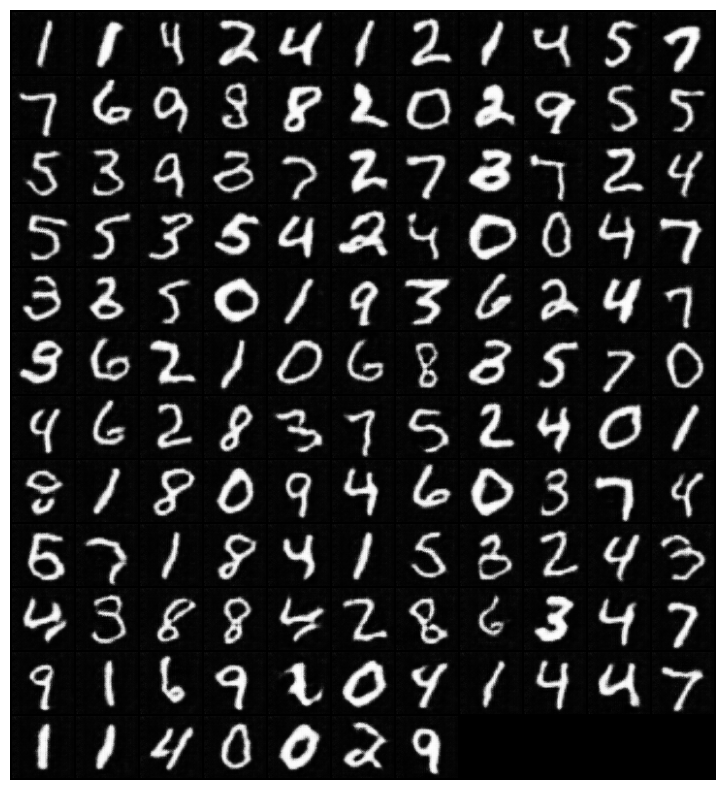

epoch n°3/5, batch:2/469 - lossLabels(0.707, 0.314, 1.04) - correctLabels(50.8%, 100.0%, 7.0%) - lossClasses(0.102, 0.00561, 0.0052) - correctClasses(96.9%, 100.0%, 100.0%) - mean(-0.734, -0.698) - std(0.585, 0.565)
epoch n°3/5, batch:3/469 - lossLabels(0.29, 0.897, 1.6) - correctLabels(100.0%, 22.7%, 0.0%) - lossClasses(0.0524, 0.0173, 0.0125) - correctClasses(97.7%, 99.2%, 100.0%) - mean(-0.738, -0.697) - std(0.578, 0.566)
epoch n°3/5, batch:4/469 - lossLabels(0.944, 0.329, 0.797) - correctLabels(14.1%, 100.0%, 32.8%) - lossClasses(0.0855, 0.00411, 0.00433) - correctClasses(96.1%, 100.0%, 100.0%) - mean(-0.74, -0.7) - std(0.578, 0.559)
epoch n°3/5, batch:5/469 - lossLabels(0.319, 0.828, 1.56) - correctLabels(97.7%, 25.8%, 0.0%) - lossClasses(0.101, 0.00237, 0.00271) - correctClasses(96.9%, 100.0%, 100.0%) - mean(-0.733, -0.701) - std(0.586, 0.554)
epoch n°3/5, batch:6/469 - lossLabels(0.71, 0.317, 0.967) - correctLabels(46.9%, 100.0%, 9.4%) - lossClasses(0.0467, 0.0152, 0.00833) - co

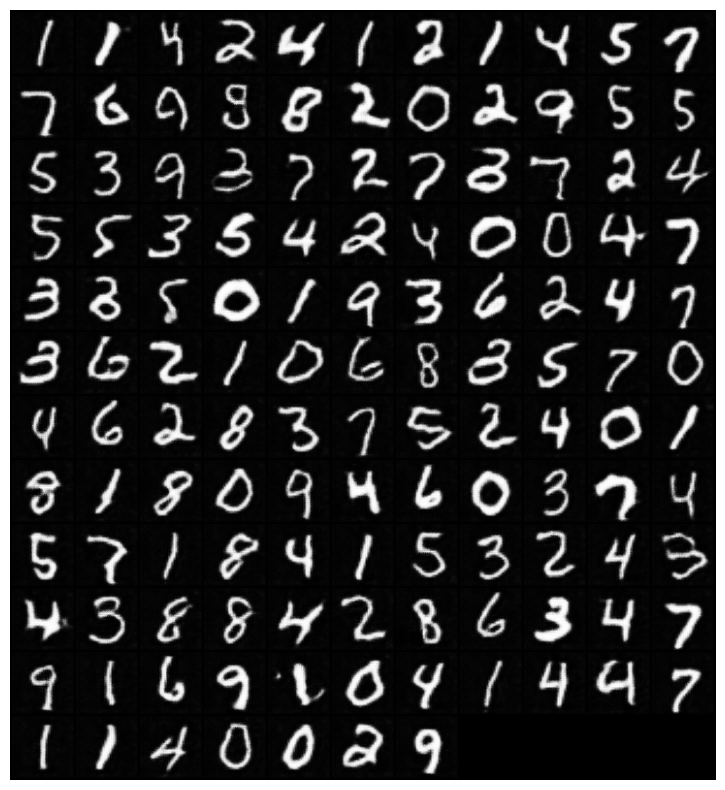

epoch n°4/5, batch:2/469 - lossLabels(0.514, 0.245, 1.5) - correctLabels(80.5%, 100.0%, 0.0%) - lossClasses(0.0847, 0.00262, 0.00291) - correctClasses(96.9%, 100.0%, 100.0%) - mean(-0.734, -0.721) - std(0.585, 0.548)
epoch n°4/5, batch:3/469 - lossLabels(0.108, 1.18, 3.1) - correctLabels(100.0%, 5.5%, 0.0%) - lossClasses(0.0461, 0.0141, 0.00702) - correctClasses(98.4%, 99.2%, 100.0%) - mean(-0.738, -0.732) - std(0.578, 0.536)
epoch n°4/5, batch:4/469 - lossLabels(1.56, 0.0854, 0.724) - correctLabels(0.8%, 100.0%, 48.4%) - lossClasses(0.0782, 0.00615, 0.00787) - correctClasses(96.9%, 100.0%, 100.0%) - mean(-0.74, -0.721) - std(0.578, 0.551)
epoch n°4/5, batch:5/469 - lossLabels(0.141, 1.07, 2.07) - correctLabels(100.0%, 10.2%, 0.0%) - lossClasses(0.0617, 0.002, 0.00198) - correctClasses(96.9%, 100.0%, 100.0%) - mean(-0.733, -0.709) - std(0.586, 0.562)
epoch n°4/5, batch:6/469 - lossLabels(0.961, 0.29, 0.725) - correctLabels(17.2%, 100.0%, 52.3%) - lossClasses(0.0422, 0.00171, 0.00165) -

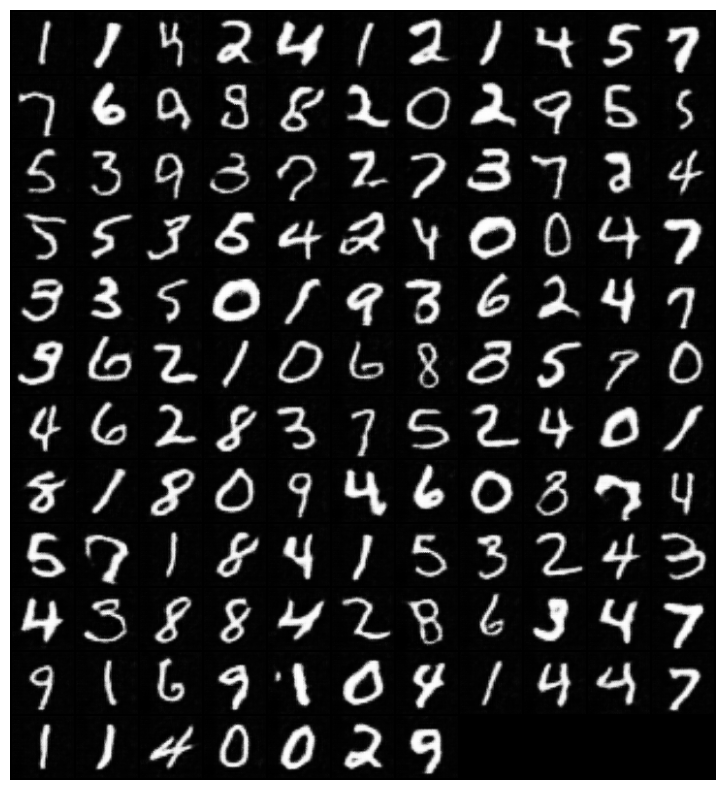

epoch n°5/5, batch:2/469 - lossLabels(0.0491, 0.878, 3.83) - correctLabels(100.0%, 30.5%, 0.0%) - lossClasses(0.0711, 0.00227, 0.00313) - correctClasses(97.7%, 100.0%, 100.0%) - mean(-0.734, -0.715) - std(0.585, 0.568)
epoch n°5/5, batch:3/469 - lossLabels(1.29, 0.104, 0.242) - correctLabels(8.6%, 100.0%, 98.4%) - lossClasses(0.046, 0.0029, 0.00242) - correctClasses(97.7%, 100.0%, 100.0%) - mean(-0.738, -0.707) - std(0.578, 0.578)
epoch n°5/5, batch:4/469 - lossLabels(0.0549, 1.74, 5.02) - correctLabels(100.0%, 0.0%, 0.0%) - lossClasses(0.0636, 0.00284, 0.00548) - correctClasses(97.7%, 100.0%, 100.0%) - mean(-0.74, -0.713) - std(0.578, 0.571)
epoch n°5/5, batch:5/469 - lossLabels(4.11, 0.0242, 2.47) - correctLabels(0.0%, 100.0%, 0.0%) - lossClasses(0.0465, 0.00712, 0.0042) - correctClasses(99.2%, 100.0%, 100.0%) - mean(-0.733, -0.727) - std(0.586, 0.553)
epoch n°5/5, batch:6/469 - lossLabels(2.28, 0.152, 0.914) - correctLabels(0.0%, 100.0%, 24.2%) - lossClasses(0.0544, 0.00412, 0.00386

In [20]:
# Training Loop

try: epoch += 1
except: epoch = 0
lastEpoch = epoch + EPOCH_NUM

try: _ = batchesStats
except: batchesStats: list[TrainBatchStepResults] = []

print("Starting Training Loop...")
for epoch in range(epoch, lastEpoch):
    
    for batch, (images, targets) in enumerate(dataloader, 0):
        targets = targets.to(device)
        
        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        realImages = images.to(device)
        sizeOfBatch = realImages.size(0)
        discRealTrueLabel = torch.full((sizeOfBatch,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        (discRealPredLabel, discRealPredClasses) = netD(realImages)
        # Calculate loss on all-real batch
        discRealLabelLoss = labelCriterion(discRealPredLabel, discRealTrueLabel)
        discRealClassesLoss = ClassesCriterion(discRealPredClasses, targets)
        # Calculate gradients for D in backward pass
        discRealLabelLoss.backward(retain_graph=True)
        discRealClassesLoss.backward()
        # Compute the correct predictions of D for the real batche
        discRealCorrectLabels = computeNbCorrectLabels(discRealPredLabel, discRealTrueLabel)
        discRealCorrectClasses = computeNbCorrectClasses(discRealPredClasses, targets)
        # print(f"discRealCorrectLabels={discRealCorrectLabels/sizeOfBatch:.1%}, discRealCorrectClasses={discRealCorrectClasses/sizeOfBatch:.2%}")
        
        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(sizeOfBatch, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fakeImages = netG(noise, targets)
        discFakeTrueLabel = torch.full((sizeOfBatch,), FAKE_LABEL, dtype=torch.float, device=device)
        # Classify all fake batch with D
        (discFakePredLabel, discFakePredClasses) = netD(fakeImages.detach())
        # Calculate loss on all-fake batch (maybe no loss on classes for the fake batch ?)
        discFakeLabelLoss = labelCriterion(discFakePredLabel, discFakeTrueLabel)
        discFakeClassesLoss = ClassesCriterion(discFakePredClasses, targets)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discFakeLabelLoss.backward(retain_graph=True)
        discFakeClassesLoss.backward()
        # Compute the correct predictions of D for the real batch
        discFakeCorrectLabels = computeNbCorrectLabels(discFakePredLabel, discFakeTrueLabel)
        discFakeCorrectClasses = computeNbCorrectClasses(discFakePredClasses, targets)
        # print(f"discFakeCorrectLabels={discFakeCorrectLabels/sizeOfBatch:.1%}, discFakeCorrectClasses={discFakeCorrectClasses/sizeOfBatch:.2%}")
        # Update D
        optimizerD.step()
        
        # (3) Update the generator with fake data
        netG.zero_grad()
        # fake labels are real for generator cost
        genTrueLabel = torch.full((sizeOfBatch,), REAL_LABEL, dtype=torch.float, device=device) 
        # Since we just updated D, perform another forward pass of all-fake batch through D
        (genPredLabel, genPredClasses) = netD(fakeImages)
        # Calculate G's loss based on this output
        genLabelLoss = labelCriterion(genPredLabel, genTrueLabel)
        genClassesLoss = ClassesCriterion(genPredClasses, targets)
        # Calculate gradients for G in backward pass
        genLabelLoss.backward(retain_graph=True)
        genClassesLoss.backward()
        # Compute the correct predictions of D for the fake batche after D's update
        genCorrectLabels = computeNbCorrectLabels(genPredLabel, genTrueLabel)
        genCorrectClasses = computeNbCorrectClasses(genPredClasses, targets)
        # print(f"genCorrectLabels={genCorrectLabels/sizeOfBatch:.1%}, genCorrectClasses={genCorrectClasses/sizeOfBatch:.2%}")
        # Update G
        optimizerG.step()
        
        batchesStats.append(TrainBatchStepResults(
            epoch, batch, sizeOfBatch,
            discRealCorrectLabels, discFakeCorrectLabels, genCorrectLabels,
            discRealCorrectClasses, discFakeCorrectClasses, genCorrectClasses, 
            discRealLabelLoss.item(), discFakeLabelLoss.item(), genLabelLoss.item(), 
            discRealClassesLoss.item(), discFakeClassesLoss.item(), genClassesLoss.item(),
            realImages.mean().item(), fakeImages.mean().item(), 
            realImages.std().item(), fakeImages.std().item(), ))
        
        # Output training stats
        print(batchesStats[-1].toText(lastEpoch=lastEpoch, nbBatchs=len(dataloader)))
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (batch == 0) or (((epoch == lastEpoch) and (batch == len(dataloader)-1))):
            with torch.no_grad():
                viz_fakeImages = netG(viz_noise, viz_targets).detach()
            plt.figure(figsize=(10,10))
            showImagesPan(viz_fakeImages)


In [21]:
epochsStats = TrainBatchStepResults.accumPerEpochStats(batchesStats)
print(*map(lambda t: t.toText(epochsStats[-1].epoch+1, 0), epochsStats), sep="\n")

epoch n°1/5, batch:0/0 - lossLabels(0.605, 0.62, 1.05) - correctLabels(69.7%, 66.4%, 13.0%) - lossClasses(0.371, 0.184, 0.174) - correctClasses(91.2%, 96.9%, 97.4%) - mean(-0.739, -0.689) - std(0.578, 0.564)
epoch n°2/5, batch:0/0 - lossLabels(0.638, 0.627, 1.01) - correctLabels(63.2%, 65.5%, 17.4%) - lossClasses(0.0809, 0.0104, 0.00888) - correctClasses(97.6%, 99.9%, 100.0%) - mean(-0.739, -0.704) - std(0.578, 0.548)
epoch n°3/5, batch:0/0 - lossLabels(0.596, 0.591, 1.27) - correctLabels(68.0%, 68.5%, 10.9%) - lossClasses(0.0532, 0.00857, 0.00637) - correctClasses(98.4%, 99.8%, 100.0%) - mean(-0.739, -0.71) - std(0.578, 0.554)
epoch n°4/5, batch:0/0 - lossLabels(0.562, 0.542, 1.59) - correctLabels(71.9%, 72.5%, 5.4%) - lossClasses(0.0414, 0.00869, 0.00597) - correctClasses(98.7%, 99.8%, 99.9%) - mean(-0.739, -0.719) - std(0.578, 0.56)
epoch n°5/5, batch:0/0 - lossLabels(0.581, 0.545, 1.55) - correctLabels(71.8%, 73.8%, 4.6%) - lossClasses(0.0335, 0.00694, 0.00443) - correctClasses(99.

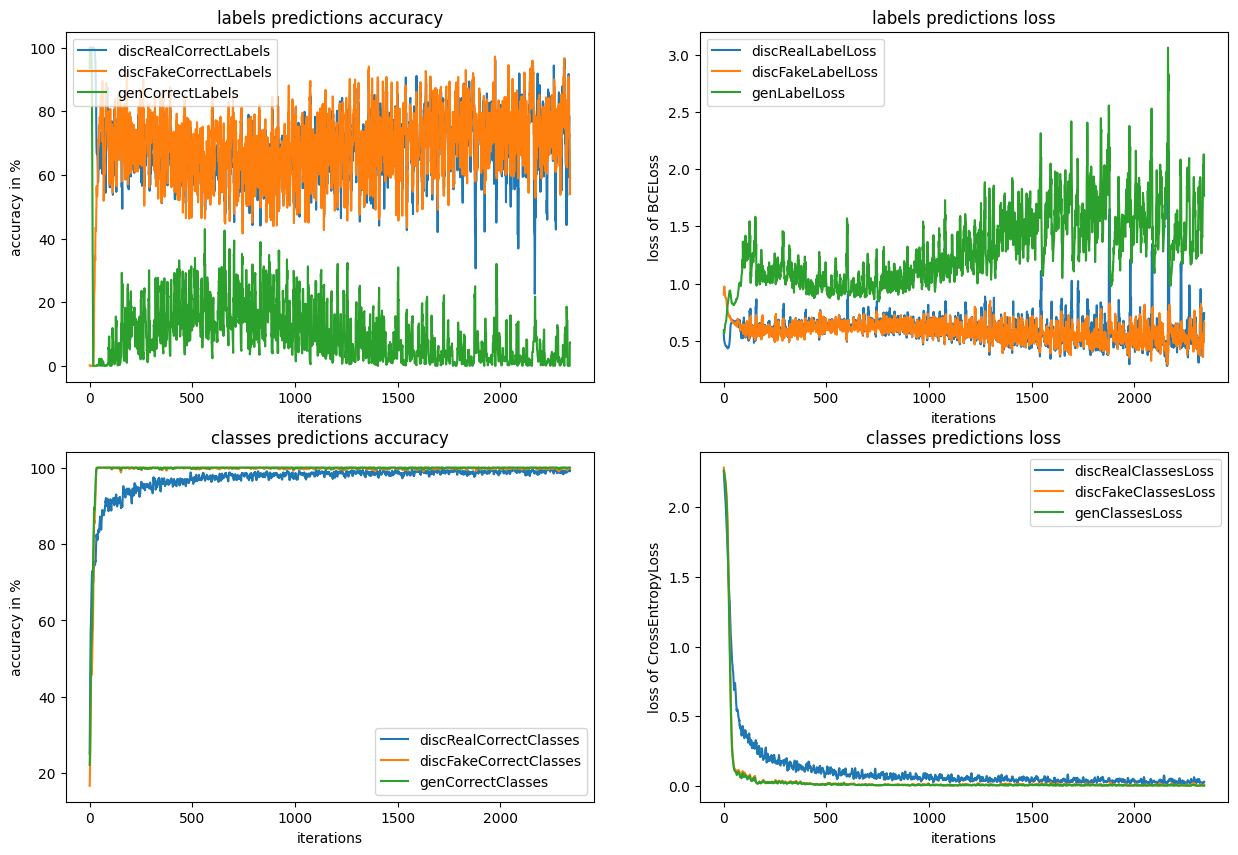

In [22]:
def smooth(y:np.ndarray|list[float]):
    box_pts: int = 5
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, "valid")
    return y_smooth

plt.figure(figsize=(15, 10))


plt.subplot(2,2,1)
plt.title("labels predictions accuracy")
plt.xlabel("iterations")
plt.ylabel(rf"accuracy in %")
plt.plot(smooth([100*batchStat.discRealCorrectLabels/batchStat.bSize for batchStat in batchesStats]), label="discRealCorrectLabels")
plt.plot(smooth([100*batchStat.discFakeCorrectLabels/batchStat.bSize for batchStat in batchesStats]), label="discFakeCorrectLabels")
plt.plot(smooth([100*batchStat.genCorrectLabels/batchStat.bSize for batchStat in batchesStats]), label="genCorrectLabels")
plt.legend()

plt.subplot(2,2,2)
plt.title("labels predictions loss")
plt.xlabel("iterations")
plt.ylabel(rf"loss of {labelCriterion._get_name()}")
plt.plot(smooth([batchStat.discRealLabelLoss for batchStat in batchesStats]), label="discRealLabelLoss")
plt.plot(smooth([batchStat.discFakeLabelLoss for batchStat in batchesStats]), label="discFakeLabelLoss")
plt.plot(smooth([batchStat.genLabelLoss for batchStat in batchesStats]), label="genLabelLoss")
plt.legend()

plt.subplot(2,2,3)
plt.title("classes predictions accuracy")
plt.xlabel("iterations")
plt.ylabel(rf"accuracy in %")
plt.plot(smooth([100*batchStat.discRealCorrectClasses/batchStat.bSize for batchStat in batchesStats]), label="discRealCorrectClasses")
plt.plot(smooth([100*batchStat.discFakeCorrectClasses/batchStat.bSize for batchStat in batchesStats]), label="discFakeCorrectClasses")
plt.plot(smooth([100*batchStat.genCorrectClasses/batchStat.bSize for batchStat in batchesStats]), label="genCorrectClasses")
plt.legend()

plt.subplot(2,2,4)
plt.title("classes predictions loss")
plt.xlabel("iterations")
plt.ylabel(rf"loss of {ClassesCriterion._get_name()}")
plt.plot(smooth([batchStat.discRealClassesLoss for batchStat in batchesStats]), label="discRealClassesLoss")
plt.plot(smooth([batchStat.discFakeClassesLoss for batchStat in batchesStats]), label="discFakeClassesLoss")
plt.plot(smooth([batchStat.genClassesLoss for batchStat in batchesStats]), label="genClassesLoss")
plt.legend()

plt.show()

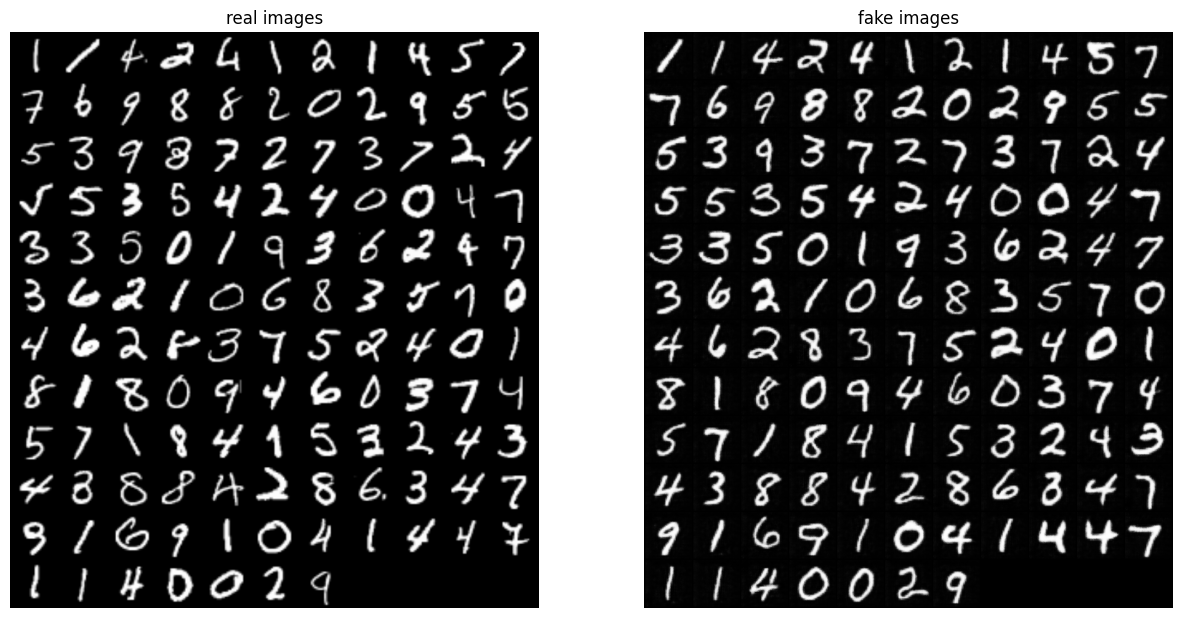

In [23]:
# Grab a batch of real images from the dataloader
real_images, real_targets = dataloader[0]

# generate the fake images from the same classes as the real images
with torch.no_grad():
    viz_fakeImages = netG(torch.randn(real_targets.size(0), Z_DIM, 1, 1, device=device)*0.7, real_targets.to(device)).detach()

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
showImagesPan(real_images, "real images", show=False)

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
showImagesPan(viz_fakeImages, "fake images", show=False)
plt.show()

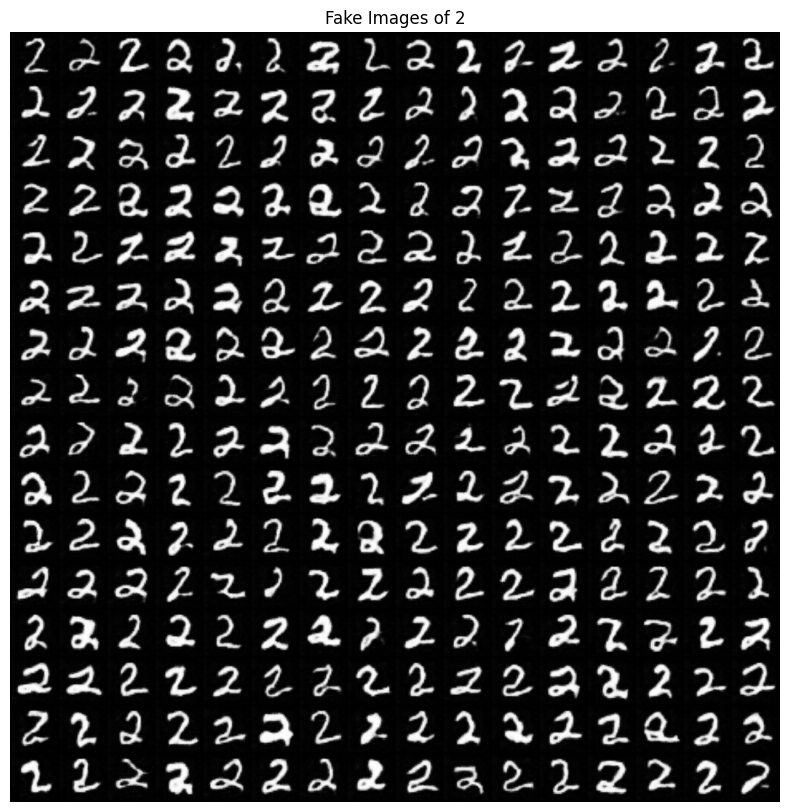

In [24]:
# generate the fake images from the same classe
targetedClass: int = 2
targets = torch.zeros((256, 10), device=device); targets[:, targetedClass] = 1.0
noises = torch.randn(targets.size(0), Z_DIM, 1, 1, device=device) * 0.7

with torch.no_grad():
    viz_fakeImages = netG(noises, targets).detach()

# Plot the fake images
plt.figure(figsize=(10,10))
showImagesPan(viz_fakeImages, f"Fake Images of {targetedClass}")

(-3.295714855194092, 3.766531467437744, 0.05346684530377388, 0.75)


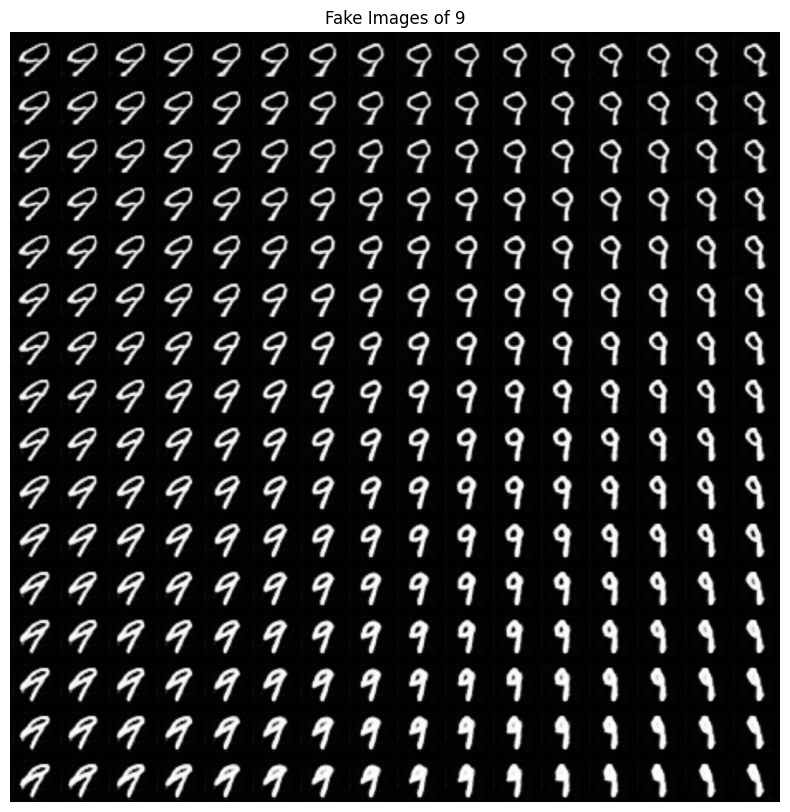

In [25]:
# generate the fake images from the same classe with 2d directional noise
targetedClass: int = 9
targets = torch.zeros((256, 10), device=device); targets[:, targetedClass] = 1.0
proj = (torch.randn(2, Z_DIM, device=device) - 0.5)
noises = torch.zeros((targets.size(0), 2), device=device)
n = int(noises.size(0)**0.5)
for y in range(n):
    for x in range(n):
        noises[x+y*n, :] = torch.tensor((x-n/2, y-n/2))
# project the noise generated to more dims
noises = (noises @ proj).view(-1, Z_DIM, 1, 1) #  (-1, 2) (2, D)
noises /= (2*noises.std())
noises *= 1.5
print(statsTensor(noises))

with torch.no_grad():
    viz_fakeImages = netG(noises, targets).detach()

# Plot the fake images
plt.figure(figsize=(10,10))
showImagesPan(viz_fakeImages, f"Fake Images of {targetedClass}")

torch.Size([256, 10]) (0.0, 1.0, 0.10000000149011612, 0.24271774291992188)


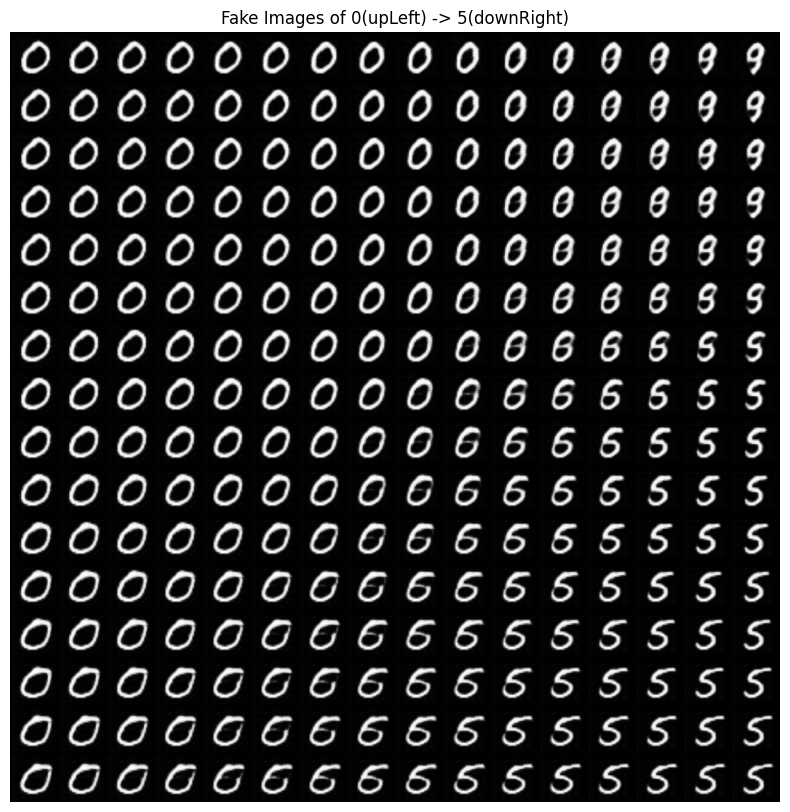

In [26]:
# generate the fake images from the same classe with 2d directional noise
targets = torch.zeros((256, 10), device=device)
(c1, c2) = (0, 5)
n = int(targets.size(0)**0.5)
for y in range(n):
    for x in range(n):
        targets[x+y*n, [c1, c2]] = torch.tensor(((1 - x/(n-1)), (y/(n-1))), device=device)
print(targets.shape, statsTensor(targets))

noises = torch.zeros((targets.size(0), Z_DIM, 1, 1), device=device)


with torch.no_grad():
    viz_fakeImages = netG(noises, targets).detach()

# Plot the fake images
plt.figure(figsize=(10,10))
showImagesPan(viz_fakeImages, f"Fake Images of {c1}(upLeft) -> {c2}(downRight)")

torch.Size([256, 10]) (0.0, 0.9963228106498718, 0.15401259064674377, 0.27624252438545227)


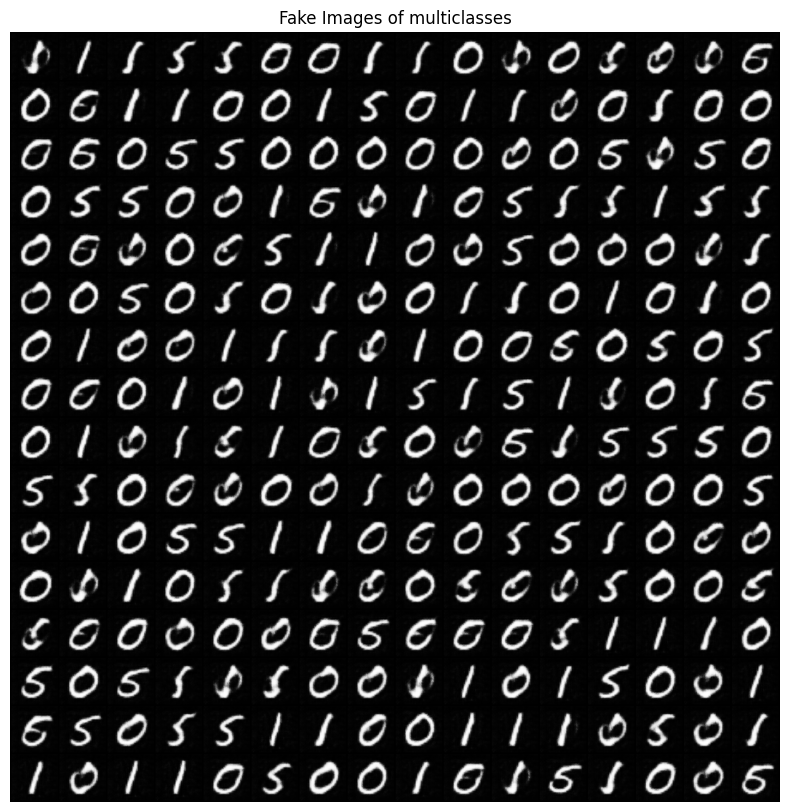

In [27]:
# generate the fake images from the same classe with 2d directional noise
targets = torch.zeros((256, 10), device=device)
targets[:, 0] = torch.rand((targets.size(0), ))
targets[:, 5] = torch.rand((targets.size(0), ))
targets[:, 1] = torch.rand((targets.size(0), ))
#targets[:, 9] = torch.rand((targets.size(0), ))
targets /= targets.norm(2, dim=1, keepdim=True)
print(targets.shape, statsTensor(targets))

noises = torch.randn(targets.size(0), Z_DIM, 1, 1, device=device) * 0.1


with torch.no_grad():
    viz_fakeImages = netG(noises, targets).detach()

# Plot the fake images
plt.figure(figsize=(10,10))
showImagesPan(viz_fakeImages, f"Fake Images of multiclasses")